#Bước 1: Chuẩn bị môi trường



In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

#Bước 2: Tải và tiền xử lý dữ liệu



Mục tiêu:



1.   Tải dữ liệu MNIST và Fashion-MNIST từ thư viện torchvision.datasets.
2.   Tiền xử lý dữ liệu để phù hợp với yêu cầu đầu vào của mô hình CNN LeNet-5 (cần ảnh kích thước 32×32).
2.   Tạo các DataLoader để quản lý batch và shuffle dữ liệu.






In [11]:
# Chuẩn bị transform: resize từ 28x28 → 32x32, chuyển sang Tensor, chuẩn hóa về [0,1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa về mean=0.5, std=0.5
])

sử dụng transforms.Compose() để ghép các bước xử lý ảnh:

1. transforms.Pad(2): thêm viền 2 pixel mỗi bên để tăng kích thước ảnh từ 28×28 thành 32×32. Điều này cần thiết vì kiến trúc LeNet-5 gốc được thiết kế cho ảnh 32×32 (tương tự ảnh trong dataset MNIST mở rộng).

2. transforms.ToTensor(): chuyển ảnh từ dạng PIL Image hoặc numpy array sang tensor PyTorch có shape (C, H, W) và giá trị pixel chuẩn hóa về khoảng [0, 1].

In [12]:
# Tải dữ liệu gốc từ torchvision
# Tải dữ liệu MNIST
train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Tải dữ liệu Fashion-MNIST
train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

Sử dụng datasets.MNIST và datasets.FashionMNIST với tham số download=True để tự động tải nếu chưa có.

Mỗi dataset gồm 60,000 ảnh huấn luyện và 10,000 ảnh kiểm thử.

Tham số transform=transform để áp dụng bước tiền xử lý đã định nghĩa ở trên cho mỗi ảnh khi được load.

In [13]:
# Tạo DataLoader
val_ratio = 0.2 # 20% dữ liệu train sẽ dùng cho validation
batch_size = 32 # Số mẫu trong mỗi batch

#MNIST
# Tính số lượng mẫu cho train & val
train_size_mnist = int((1 - val_ratio) * len(train_mnist))
val_size_mnist = len(train_mnist) - train_size_mnist

# Tách dữ liệu train thành train_set và val_set
train_mnist_set, val_mnist_set = random_split(train_mnist, [train_size_mnist, val_size_mnist])

# Tạo DataLoader cho train, val, test
train_loader_mnist = DataLoader(train_mnist_set, batch_size=batch_size, shuffle=True)   # Shuffle train
val_loader_mnist = DataLoader(val_mnist_set, batch_size=batch_size, shuffle=False)      # Val không shuffle
test_loader_mnist = DataLoader(test_mnist, batch_size=batch_size, shuffle=False)        # Test không shuffle

#Fashion-MNIST
# Tính số lượng mẫu cho train & val
train_size_fashion = int((1 - val_ratio) * len(train_fashion))
val_size_fashion = len(train_fashion) - train_size_fashion

# Tách dữ liệu train thành train_set và val_set
train_fashion_set, val_fashion_set = random_split(train_fashion, [train_size_fashion, val_size_fashion])

# Tạo DataLoader cho train, val, test
train_loader_fashion = DataLoader(train_fashion_set, batch_size=batch_size, shuffle=True)
val_loader_fashion = DataLoader(val_fashion_set, batch_size=batch_size, shuffle=False)
test_loader_fashion = DataLoader(test_fashion, batch_size=batch_size, shuffle=False)

DataLoader giúp chia dữ liệu thành từng batch, shuffle dữ liệu trong giai đoạn huấn luyện để mô hình không học theo thứ tự cố định.

batch_size=32: mỗi lần huấn luyện, mô hình xử lý 32 ảnh cùng lúc.

shuffle=True trong tập huấn luyện để tăng tính ngẫu nhiên, giúp mô hình tổng quát hóa tốt hơn.

In [14]:
# Kiểm tra kích thước dataset
print("MNIST Train size:", len(train_mnist_set))
print("MNIST Val size:", len(val_mnist_set))
print("MNIST Test size:", len(test_mnist))
print("Fashion-MNIST Train size:", len(train_fashion_set))
print("Fashion-MNIST Val size:", len(val_fashion_set))
print("Fashion-MNIST Test size:", len(test_fashion))


MNIST Train size: 48000
MNIST Val size: 12000
MNIST Test size: 10000
Fashion-MNIST Train size: 48000
Fashion-MNIST Val size: 12000
Fashion-MNIST Test size: 10000


In ra số lượng mẫu trong tập train/test của mỗi dataset để xác nhận dữ liệu đã được tải thành công.

#Bước 3: Xây dựng mô hình LeNet-5



Kiến trúc LeNet-5 (Baseline)

LeNet-5 là một trong những CNN đầu tiên, được thiết kế cho nhận diện chữ số viết tay. Nó bao gồm:
Input: Ảnh 32x32 (MNIST và Fashion MNIST là 28x28, nên ta sẽ padding để khớp).

C1: Lớp tích chập với 6 filters, kernel 5x5, activation ReLU (thay vì tanh gốc).

S2: Lớp pooling (Average Pooling hoặc Max Pooling) kích thước 2x2.

C3: Lớp tích chập với 16 filters, kernel 5x5, activation ReLU.

S4: Lớp pooling kích thước 2x2.

C5: Lớp fully connected (Dense) với 120 neurons.

F6: Lớp fully connected với 84 neurons.

Output: Lớp fully connected với 10 neurons (softmax).

Ta sẽ sử dụng MaxPooling thay cho Average Pooling và điều chỉnh input từ 28x28 thành 32x32 bằng padding.


In [15]:
# Đưa mô hình lên GPU nếu có (torch.device("cuda")) để tăng tốc huấn luyện.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Định nghĩa kiến trúc LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # C1: Convolution layer
        # Input: 1 x 32 x 32 (ảnh grayscale đã resize)
        # Output: 6 x 28 x 28 (do kernel_size=5, stride=1, padding=0 → giảm 4 pixel mỗi chiều)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # S2: Subsampling (MaxPooling)
        # Input: 6 x 28 x 28
        # Output: 6 x 14 x 14 (pool_size=2x2, stride=2 → giảm 1/2 kích thước)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # C3: Convolution layer
        # Input: 6 x 14 x 14
        # Output: 16 x 10 x 10 (kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # S4: Subsampling (MaxPooling)
        # Input: 16 x 10 x 10
        # Output: 16 x 5 x 5
        # Flatten: 16 * 5 * 5 = 400 neurons
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # C5: Fully Connected
        # F6: Fully Connected layer
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 10 lớp (tương ứng 10 số hoặc 10 loại quần áo)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # C1 + ReLU
        x = F.relu(self.conv1(x))       # Output: (6, 28, 28)
        # S2: MaxPooling
        x = self.pool(x)                # Output: (6, 14, 14)
        # C3 + ReLU
        x = F.relu(self.conv2(x))       # Output: (16, 10, 10)
        # S4: MaxPooling
        x = self.pool(x)                # Output: (16, 5, 5)
        # Flatten
        x = x.view(-1, 16 * 5 * 5)      # Output: (batch_size, 400)
        # C5 + ReLU
        x = F.relu(self.fc1(x))
        # F6 + ReLU
        x = F.relu(self.fc2(x))
        # Output layer (logits, chưa softmax vì dùng CrossEntropyLoss)
        x = self.fc3(x)

        return x


Định nghĩa một class kế thừa nn.Module để mô tả kiến trúc LeNet-5, Cấu trúc gồm:

C1: Convolution với 6 bộ lọc kích thước 5×5, đầu vào là ảnh 1 kênh (grayscale), padding=0 → output size 28×28×6.

S2: MaxPooling 2×2 để giảm kích thước xuống 14×14×6.

C3: Convolution với 16 bộ lọc kích thước 5×5, output size 10×10×16.

S4: MaxPooling 2×2, output size 5×5×16.

Flatten: Chuyển tensor thành vector 400 phần tử (16×5×5).

C5: Fully connected 120 neuron.

F6: Fully connected 84 neuron.

Output: Fully connected 10 neuron, ứng với 10 lớp phân loại.

Trong forward() sử dụng F.relu() cho các lớp ẩn, output cuối chỉ trả về logits (chưa softmax) vì hàm mất mát sẽ xử lý.

In [17]:
# Khởi tạo mô hình cho MNIST và Fashion MNIST
model_mnist = LeNet5().to(device)
model_fashion = LeNet5().to(device)

# Optimizer và Loss Function
criterion = nn.CrossEntropyLoss()
optimizer_mnist = torch.optim.Adam(model_mnist.parameters(), lr=0.001)
optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=0.001)

# In cấu trúc model để kiểm tra số lượng layer, kích thước đầu vào/đầu ra.
print("Model MNIST:")
print(model_mnist)

print("\nModel Fashion MNIST:")
print(model_fashion)


Model MNIST:
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Model Fashion MNIST:
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#Bước 4: Huấn luyện mô hình



In [18]:
# Hàm huấn luyện
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Lưu vào history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # In kết quả mỗi epoch
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"- Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    return history


# Huấn luyện MNIST
print("=== Huấn luyện MNIST ===")
history_mnist = train_model(
    model_mnist,
    train_loader_mnist,
    val_loader_mnist,
    optimizer_mnist,
    criterion,
    epochs=10
)

# uấn luyện Fashion MNIST
print("\n=== Huấn luyện Fashion MNIST ===")
history_fashion = train_model(
    model_fashion,
    train_loader_fashion,
    val_loader_fashion,
    optimizer_fashion,
    criterion,
    epochs=10
)


=== Huấn luyện MNIST ===
Epoch [1/10] - Train Loss: 0.2326 - Train Acc: 0.9265 - Val Loss: 0.0795 - Val Acc: 0.9753
Epoch [2/10] - Train Loss: 0.0699 - Train Acc: 0.9784 - Val Loss: 0.0618 - Val Acc: 0.9817
Epoch [3/10] - Train Loss: 0.0504 - Train Acc: 0.9846 - Val Loss: 0.0506 - Val Acc: 0.9836
Epoch [4/10] - Train Loss: 0.0400 - Train Acc: 0.9882 - Val Loss: 0.0545 - Val Acc: 0.9838
Epoch [5/10] - Train Loss: 0.0334 - Train Acc: 0.9897 - Val Loss: 0.0442 - Val Acc: 0.9860
Epoch [6/10] - Train Loss: 0.0260 - Train Acc: 0.9920 - Val Loss: 0.0442 - Val Acc: 0.9875
Epoch [7/10] - Train Loss: 0.0231 - Train Acc: 0.9927 - Val Loss: 0.0484 - Val Acc: 0.9872
Epoch [8/10] - Train Loss: 0.0211 - Train Acc: 0.9934 - Val Loss: 0.0480 - Val Acc: 0.9877
Epoch [9/10] - Train Loss: 0.0185 - Train Acc: 0.9940 - Val Loss: 0.0537 - Val Acc: 0.9865
Epoch [10/10] - Train Loss: 0.0159 - Train Acc: 0.9947 - Val Loss: 0.0527 - Val Acc: 0.9878

=== Huấn luyện Fashion MNIST ===
Epoch [1/10] - Train Loss: 0.5

#Bước 5: Đánh giá mô hình



In [19]:
#Hàm đánh giá mô hình trên tập test
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Chuyển sang chế độ đánh giá (không dropout, batchnorm cố định)
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Không tính gradient khi đánh giá
        for inputs, targets in test_loader:
            # Đưa dữ liệu lên GPU (nếu có)
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Cộng dồn loss và số lượng dự đoán đúng
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    # Tính trung bình loss và accuracy
    avg_loss = test_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# Đánh giá MNIST
mnist_loss, mnist_acc = evaluate_model(model_mnist, test_loader_mnist, criterion)
print(f"Độ chính xác trên tập test của MNIST: {mnist_acc:.4f}")
print(f"Giá trị mất mát trên tập test của MNIST: {mnist_loss:.4f}")

# Đánh giá Fashion MNIST
fashion_loss, fashion_acc = evaluate_model(model_fashion, test_loader_fashion, criterion)
print(f"Độ chính xác trên tập test của Fashion MNIST: {fashion_acc:.4f}")
print(f"Giá trị mất mát trên tập test của Fashion MNIST: {fashion_loss:.4f}")

Độ chính xác trên tập test của MNIST: 0.9894
Giá trị mất mát trên tập test của MNIST: 0.0426
Độ chính xác trên tập test của Fashion MNIST: 0.8993
Giá trị mất mát trên tập test của Fashion MNIST: 0.2966


#Bước 6: Vẽ đồ thị Loss và Accuracy



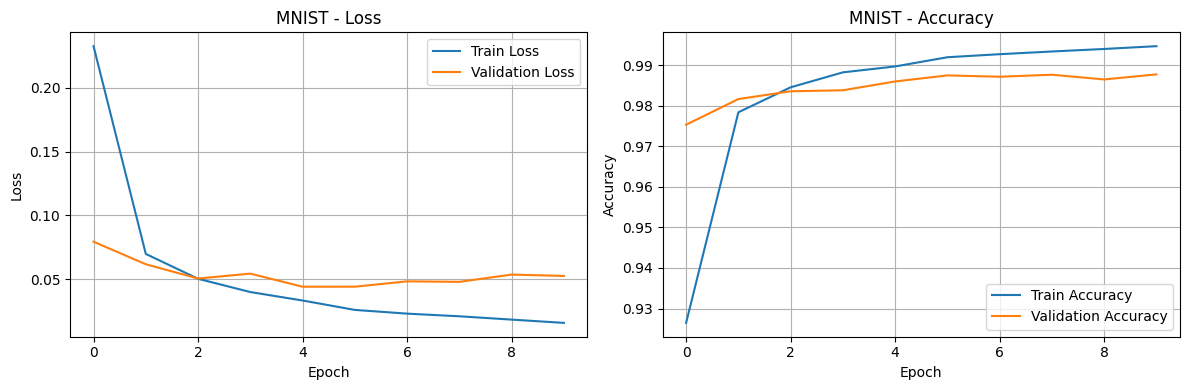

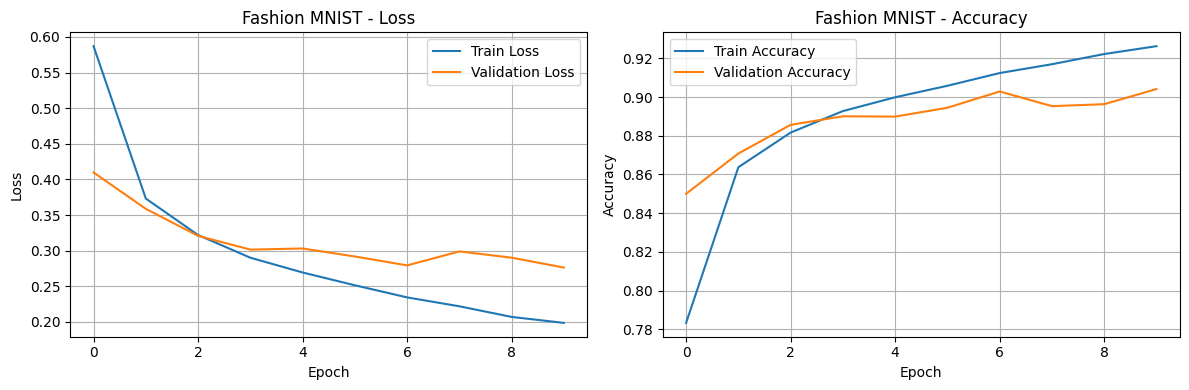

In [22]:
# Hàm vẽ đồ thị Loss và Accuracy
def plot_history(history, title, save_path=None):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)  # Thêm lưới
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)  # Thêm lưới
    plt.legend()

    # Lưu đồ thị nếu có đường dẫn
    if save_path:
        plt.savefig(save_path)

    plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các subplot
    plt.show()

# Vẽ đồ thị cho MNIST
plot_history(history_mnist, 'MNIST', save_path='mnist_history.png')

# Vẽ đồ thị cho Fashion-MNIST
plot_history(history_fashion, 'Fashion MNIST', save_path='fashion_mnist_history.png')

#Bước 7: Dự đoán và hiển thị 5 mẫu



In [24]:
# Hàm hiển thị 5 mẫu dự đoán
def visualize_predictions(model, test_loader, title, device, num_samples=5):
    model.eval()  # Chuyển sang chế độ đánh giá
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Đưa dữ liệu lên device (GPU/CPU)
            inputs = inputs.to(device)
            # Dự đoán
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # Chuyển dữ liệu về CPU và numpy
            images.extend(inputs.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            # Lấy đủ num_samples thì dừng
            if len(images) >= num_samples:
                break

    # Vẽ 5 mẫu
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')  # Reshape ảnh 32x32
        plt.title(f"Dự đoán: {predicted_labels[i]}\nThực tế: {true_labels[i]}", fontsize=10)
        plt.axis('off')
    plt.suptitle(f"{num_samples} mẫu dự đoán từ {title}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


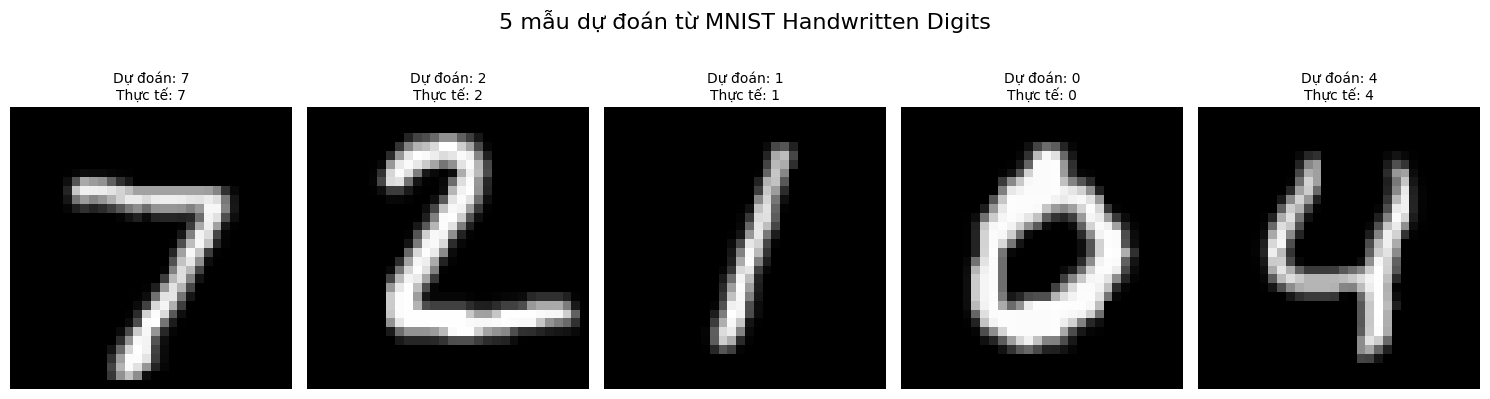

In [25]:
# Dự đoán và hiển thị cho MNIST
visualize_predictions(model_mnist, test_loader_mnist, "MNIST Handwritten Digits", device)


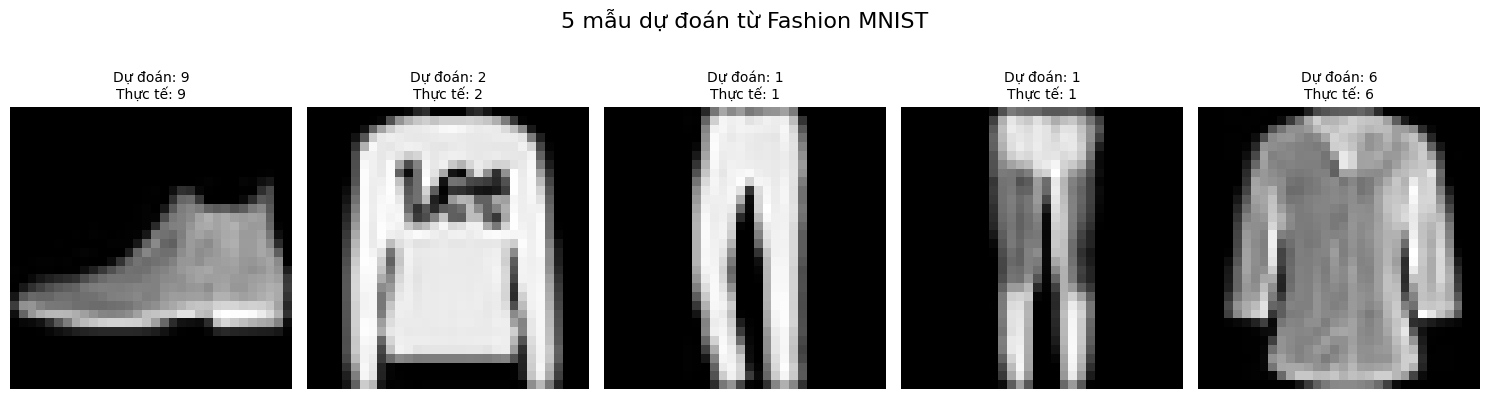

In [26]:
# Dự đoán và hiển thị cho Fashion-MNIST
visualize_predictions(model_fashion, test_loader_fashion, "Fashion MNIST", device)